In [2]:
import os
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#import matplotlib.pyplot as plt

In [3]:
from v2.unet import Unet
from v2.dataset import CustomSegmentationDataset

In [13]:
model = Unet(3, 19)

root_path = 'Data/data/'

data_train = CustomSegmentationDataset(root_path + 'train/image/', root_path + 'train/label/')
data_val = CustomSegmentationDataset(root_path + 'val/image/', root_path + 'val/label')

train_loader = DataLoader(data_train, batch_size=8, shuffle=True)
val_loader = DataLoader(data_val, batch_size=8, shuffle=False)

In [17]:
checkpoint_path = '/Users/vadimartemov/Desktop/project/checkpoints/checkpoint_epoch_79.pth'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [19]:
def accuracy_ignore_negative_one(preds, targets):
    """
    Compute the accuracy, ignoring target indices with a value of -1.

    Args:
        preds (torch.Tensor): Predictions from the model, shape (batch_size, num_classes).
        targets (torch.Tensor): Ground truth labels, shape (batch_size).

    Returns:
        float: Accuracy score.
    """
    # Ensure the predictions are in the form of class indices
    _, predicted_labels = torch.max(preds, dim=1)
    
    # Filter out indices where the target is -1
    valid_indices = targets != -1
    valid_targets = targets * valid_indices
    valid_predictions = predicted_labels * valid_indices

    # Compute the accuracy
    correct = valid_predictions.eq(valid_targets).sum().item()
    total = valid_targets.size()[0]*valid_targets.size()[1]*valid_targets.size()[2]
    # total = valid_targets.size().sum()
    #print(correct, total)
    
    if total == 0:
        return 0.0  # If no valid targets, return 0.0 accuracy

    accuracy = correct / total
    return accuracy


In [48]:
device = torch.device('cuda' if torch.cuda.is_available() \
                      else 'mps' if torch.backends.mps.is_available() \
                      else 'cpu')

running_loss = 0.0
with torch.no_grad():
    for inputs, labels in tqdm(train_loader):
        outputs = model(inputs)
        loss = accuracy_ignore_negative_one(outputs, labels)
        running_loss += loss
        

val_loss = running_loss / len(val_loader)

val_loss

100%|█████████████████████████████████████████| 372/372 [12:13<00:00,  1.97s/it]


5.515428002459122

In [ ]:
# val_accur = 89.5%
# train_accur = .%

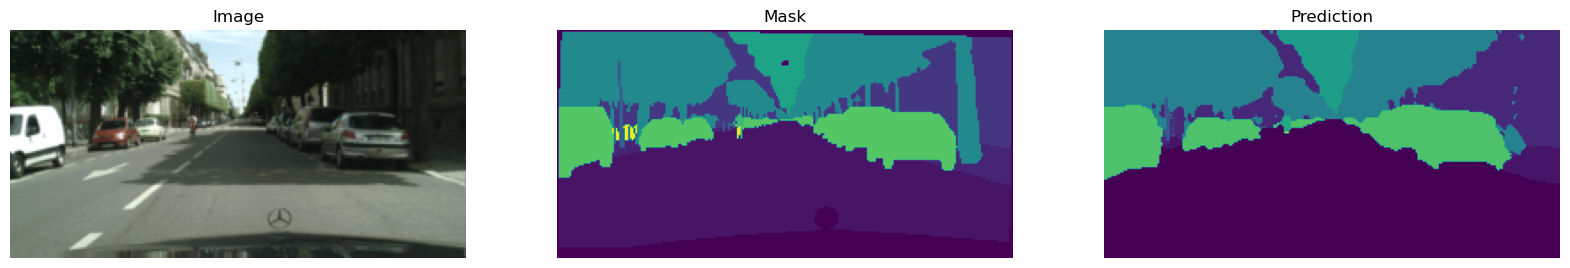

In [46]:
for input, label in train_loader:

    image_tensor = input[0]
    image = image_tensor.permute(1, 2, 0).numpy()
    label = label[0].numpy()
    predicted_label = model.forward(input).detach().numpy()[0].argmax(axis=0)
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 20))
    # Plot the image
    axs[0].imshow(image)
    axs[0].axis('off')  # Hide axes
    axs[0].set_title('Image')
    
    # Plot the mask
    axs[1].imshow(label)
    axs[1].axis('off')  # Hide axes
    axs[1].set_title('Mask')

    # Plot the Prediction
    axs[2].imshow(predicted_label)
    axs[2].axis('off')  # Hide axes
    axs[2].set_title('Prediction')
    
    plt.show()
    break

In [36]:
import matplotlib.pyplot as plt